In [3]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score, davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

# import optuna as op

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/train.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/test.csv'
file_key_3 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

In [4]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


In [6]:
train.columns[2:30]

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

In [7]:
X = train[train.columns[2:30]]
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577
1,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238
2,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356
3,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839
4,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051


In [9]:
X.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000
mean,0.096008,0.048345,0.592102,0.069273,-0.161555,0.133688,-0.128224,0.149534,-0.048337,-0.039758,0.153632,-0.061038,0.014330,0.067649,0.108643,0.013650,0.036815,-0.033927,-0.008302,0.009708,-0.031064,-0.050852,-0.050531,-0.002992,0.124005,0.009881,0.014034,0.017313
std,1.395425,1.159805,1.132884,1.253125,1.069530,1.202411,0.817207,0.716212,1.054143,0.821889,0.976946,0.998470,1.039145,0.801335,0.891613,0.786654,0.691709,0.784454,0.739928,0.439521,0.422777,0.597812,0.318175,0.593100,0.406741,0.473867,0.233355,0.164859
min,-29.807725,-44.247914,-19.722872,-5.263650,-37.591259,-25.659750,-31.179799,-28.903442,-8.756951,-22.092656,-4.190145,-16.180165,-4.373778,-15.585021,-4.155728,-11.778839,-20.756768,-7.456060,-4.281628,-18.679066,-14.689621,-8.748979,-11.958588,-2.836285,-3.958591,-1.858672,-9.234767,-4.551680
25%,-0.846135,-0.573728,-0.027154,-0.769256,-0.847346,-0.631835,-0.646730,-0.095948,-0.711444,-0.499563,-0.576969,-0.476890,-0.671601,-0.329905,-0.461596,-0.461077,-0.406675,-0.496990,-0.463035,-0.167927,-0.190418,-0.473099,-0.174478,-0.332540,-0.126080,-0.318330,-0.050983,-0.009512
50%,0.385913,0.046937,0.735895,0.064856,-0.229929,-0.087778,-0.098970,0.111219,-0.131323,-0.106034,0.090545,0.087649,-0.016837,0.049266,0.178975,0.054550,-0.013949,-0.039451,-0.002935,-0.037702,-0.042858,-0.032856,-0.063307,0.038708,0.145934,-0.086388,0.015905,0.022163
75%,1.190661,0.814145,1.306110,0.919353,0.356856,0.482388,0.385567,0.390976,0.583715,0.403967,0.917392,0.608480,0.695547,0.460837,0.791255,0.531777,0.410978,0.446448,0.455718,0.126750,0.109187,0.354910,0.060221,0.394566,0.402926,0.253869,0.076814,0.066987
max,2.430494,16.068473,6.145578,12.547997,34.581260,16.233967,39.824099,18.270586,13.423914,15.878405,9.417789,5.406614,5.976265,6.078453,4.693323,5.834992,8.845303,4.847887,4.090974,15.407839,22.062945,6.163541,12.734391,4.572739,3.111624,3.402344,13.123618,23.263746


In [10]:
scaler = MinMaxScaler()
X_trans = scaler.fit_transform(X)

In [12]:
kmeans_md = KMeans(n_clusters = 3, n_init = 20).fit(X_trans)

In [15]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


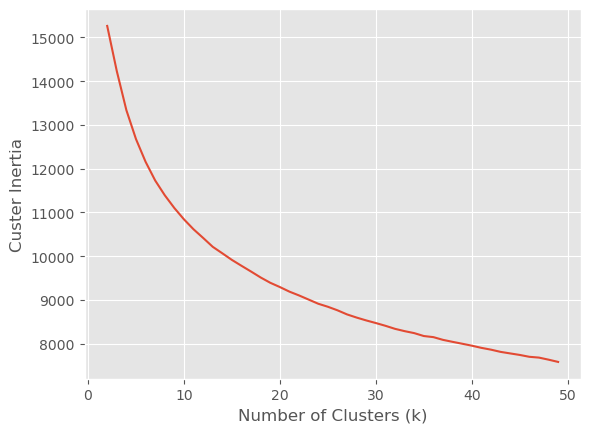

In [22]:
## Defining the number of clusters to be considered
krange = list(range(2, 100))

## Defining lists to store scores
CH_scores, DB_scores, silhouette_scores = list(), list(), list()
inertias = list()

for i in krange:
    print(i)
    ## Here we define the k-means model
    cluster_md = KMeans(n_clusters = i, n_init = 20).fit(X_trans)
    cluster_assignments = cluster_md.labels_
    inertias.append(cluster_md.inertia_)
    
#     ## Here we extract CH, DB and silhoutte scores
#     CH = calinski_harabasz_score(X_trans, cluster_assignments)
#     DB = davies_bouldin_score(X_trans, cluster_assignments)
#     silhouette = silhouette_score(X_trans, cluster_assignments)
    
#     ## Storing scores
#     CH_scores.append(CH)
#     DB_scores.append(DB)
#     silhouette_scores.append(silhouette)

plt.plot(krange, inertias)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Custer Inertia')
plt.show()
fig.savefig('V1_V28_clusters.pdf')


# ## Visualizing the scores    
# fig, axs = plt.subplots(1, 3, figsize = (20, 8))
# axs[0].plot(krange, CH_scores)
# axs[0].set_xlabel('Number of Clusters (k)')
# axs[0].set_ylabel('CH-Score')
# axs[0].grid()

# axs[1].plot(krange, DB_scores)
# axs[1].set_xlabel('Number of Clusters (k)')
# axs[1].set_ylabel('DB-Score')
# axs[1].grid()

# axs[2].plot(krange, silhouette_scores)
# axs[2].set_xlabel('Number of Clusters (k)')
# axs[2].set_ylabel('Silhouette-Score')
# axs[2].grid()